# Employee Performance & Retention Analysis
**Tasks:** EDA → Attrition (classification) → Performance (regression) → Evaluation & feature importance


In [1]:
# Basic libraries for data handling and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning tools
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report,
                             roc_auc_score, roc_curve, mean_squared_error, r2_score, mean_absolute_error)

# Display settings
%matplotlib inline
sns.set(style='whitegrid')


In [2]:
# Load dataset
df = pd.read_csv('employee_data.csv')

# Quick look
print("Shape:", df.shape)
display(df.head())
print("\nData types:")
display(df.dtypes)
print("\nMissing values per column:")
display(df.isnull().sum())


Shape: (100, 8)


,EmployeeID,Name,Age,Department,Salary,YearsAtCompany,PerformanceScore,Attrition
0,1,John Doe,29,Sales,55000,3,80,No
1,2,Jane Smith,35,HR,60000,7,85,No
2,3,Michael Brown,40,Engineering,80000,10,95,Yes
3,4,Emily Davis,28,Marketing,65000,5,78,No
4,5,David Johnson,50,Sales,75000,20,88,Yes



Data types:


EmployeeID           int64
Name                object
Age                  int64
Department          object
Salary               int64
YearsAtCompany       int64
PerformanceScore     int64
Attrition           object
dtype: object


Missing values per column:


EmployeeID          0
Name                0
Age                 0
Department          0
Salary              0
YearsAtCompany      0
PerformanceScore    0
Attrition           0
dtype: int64

Basic cleaning (drop id/name if not needed) and checks

In [3]:
# Drop columns not useful for modeling (EmployeeID and Name are identifiers)
drop_cols = []
if 'EmployeeID' in df.columns:
    drop_cols.append('EmployeeID')
if 'Name' in df.columns:
    drop_cols.append('Name')

if drop_cols:
    df = df.drop(columns=drop_cols)
    print("Dropped columns:", drop_cols)

# Check duplicates
print("Duplicate rows:", df.duplicated().sum())
df = df.drop_duplicates()


Dropped columns: ['EmployeeID', 'Name']
Duplicate rows: 0


Quick EDA (distributions & counts)

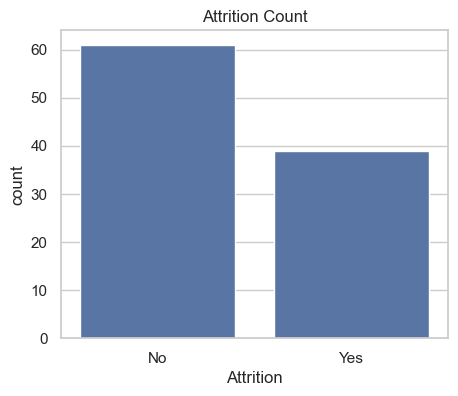

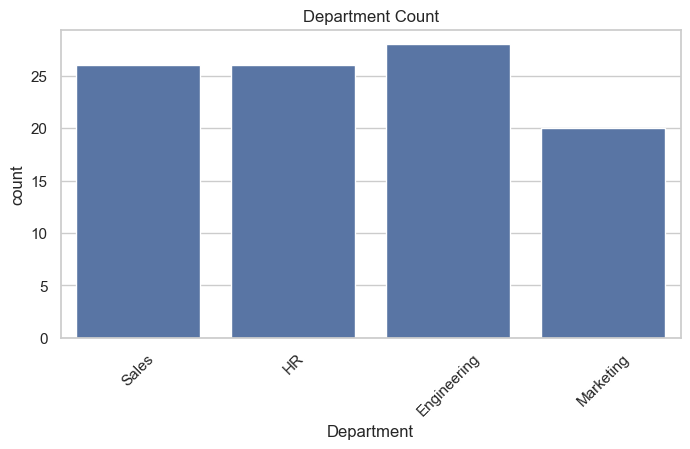

,count,mean,std,min,25%,50%,75%,max
Age,100.0,36.57,8.318478,25.0,29.75,35.0,41.25,60.0
Salary,100.0,72820.00,12643.823102,43000.0,65000.00,72000.0,82750.00,95000.0
YearsAtCompany,100.0,10.80,6.361183,1.0,5.00,10.0,16.00,25.0
PerformanceScore,100.0,84.94,6.349771,70.0,80.00,85.5,90.00,95.0


In [4]:
# Attrition counts
plt.figure(figsize=(5,4))
sns.countplot(x='Attrition', data=df)
plt.title('Attrition Count')
plt.show()

# Department distribution
plt.figure(figsize=(8,4))
sns.countplot(x='Department', data=df)
plt.title('Department Count')
plt.xticks(rotation=45)
plt.show()

# Numeric summary
display(df.describe().T)


Correlation heatmap (numeric features)

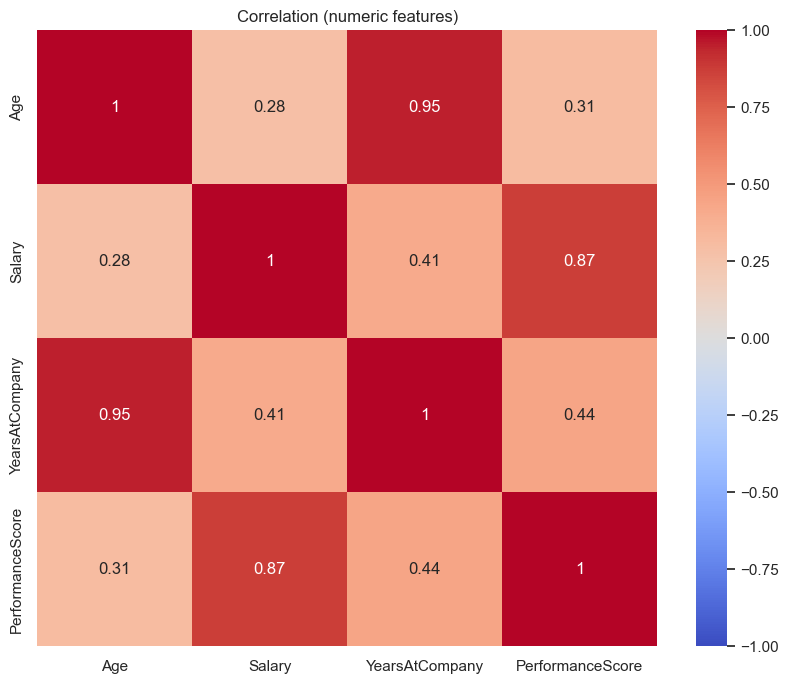

In [5]:
plt.figure(figsize=(10,8))
num_df = df.select_dtypes(include=[np.number])
corr = num_df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation (numeric features)')
plt.show()


Preprocessing for modeling

In [6]:
# 1) Encode target for classification: Attrition -> 1 (Yes), 0 (No)
df['Attrition_flag'] = df['Attrition'].map({'Yes':1, 'No':0})

# 2) One-hot encode Department (if present)
if 'Department' in df.columns:
    df = pd.get_dummies(df, columns=['Department'], drop_first=True)

# 3) Final feature list for models
# For classification we'll predict 'Attrition_flag'
# For regression we'll predict 'PerformanceScore'
features = [c for c in df.columns if c not in ['Attrition','Attrition_flag','PerformanceScore']]
print("Features used:", features)


Features used: ['Age', 'Salary', 'YearsAtCompany', 'Department_HR', 'Department_Marketing', 'Department_Sales']


Prepare data for Attrition classification

In [7]:
# X and y for classification
X_clf = df[features]
y_clf = df['Attrition_flag']

# Train-test split (stratify to keep class ratio)
Xc_train, Xc_test, yc_train, yc_test = train_test_split(
    X_clf, y_clf, test_size=0.25, random_state=42, stratify=y_clf)

print("Classification train/test shapes:", Xc_train.shape, Xc_test.shape)


Classification train/test shapes: (75, 6) (25, 6)


Train Random Forest Classifier (baseline)

In [8]:
# Baseline Random Forest classifier
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(Xc_train, yc_train)

# Predict and evaluate
yc_pred = rfc.predict(Xc_test)
yc_proba = rfc.predict_proba(Xc_test)[:,1]

print("Accuracy:", round(accuracy_score(yc_test, yc_pred), 4))
print("\nConfusion Matrix:\n", confusion_matrix(yc_test, yc_pred))
print("\nClassification Report:\n", classification_report(yc_test, yc_pred))
print("ROC AUC:", round(roc_auc_score(yc_test, yc_proba), 4))


Accuracy: 0.72

Confusion Matrix:
 [[13  2]
 [ 5  5]]

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.87      0.79        15
           1       0.71      0.50      0.59        10

    accuracy                           0.72        25
   macro avg       0.72      0.68      0.69        25
weighted avg       0.72      0.72      0.71        25

ROC AUC: 0.7167


Plot ROC curve (classification)

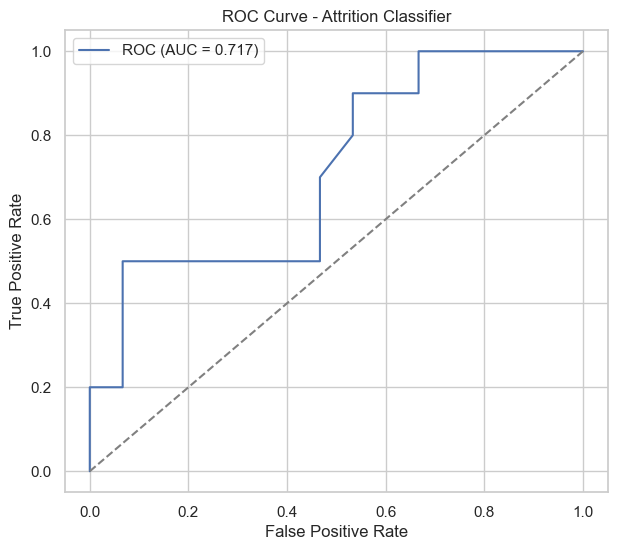

In [9]:
fpr, tpr, thr = roc_curve(yc_test, yc_proba)
plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc_score(yc_test,yc_proba):.3f})')
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Attrition Classifier')
plt.legend()
plt.grid(True)
plt.show()


Feature importance (classification)

Salary                  0.324519
Age                     0.317404
YearsAtCompany          0.251209
Department_Sales        0.038884
Department_Marketing    0.034585
Department_HR           0.033399
dtype: float64

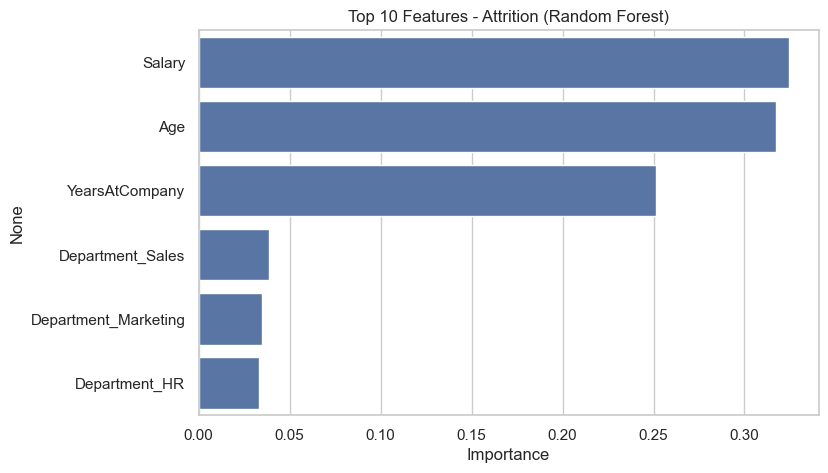

In [10]:
# Show top features for attrition prediction
feat_imp_clf = pd.Series(rfc.feature_importances_, index=Xc_train.columns).sort_values(ascending=False)
display(feat_imp_clf.head(10))

plt.figure(figsize=(8,5))
sns.barplot(x=feat_imp_clf.head(10), y=feat_imp_clf.head(10).index)
plt.title('Top 10 Features - Attrition (Random Forest)')
plt.xlabel('Importance')
plt.show()


Prepare data for Performance regression

In [11]:
# Features (can reuse features list). Target:
y_reg = df['PerformanceScore']
X_reg = df[features]

# Train-test split
Xr_train, Xr_test, yr_train, yr_test = train_test_split(
    X_reg, y_reg, test_size=0.25, random_state=42)

print("Regression train/test shapes:", Xr_train.shape, Xr_test.shape)


Regression train/test shapes: (75, 6) (25, 6)


Scale features for regression

In [12]:
# Scaling numeric features helps regression models
scaler = StandardScaler()
Xr_train_scaled = scaler.fit_transform(Xr_train)
Xr_test_scaled = scaler.transform(Xr_test)


Train Random Forest Regressor (baseline)

In [13]:
rfr = RandomForestRegressor(n_estimators=100, random_state=42)
rfr.fit(Xr_train_scaled, yr_train)

# Predict and evaluate
yr_pred = rfr.predict(Xr_test_scaled)
print("R² (test):", round(r2_score(yr_test, yr_pred), 4))
print("RMSE (test):", round(np.sqrt(mean_squared_error(yr_test, yr_pred)), 4))
print("MAE (test):", round(mean_absolute_error(yr_test, yr_pred), 4))


R² (test): 0.8465
RMSE (test): 2.8477
MAE (test): 2.0788


Residual plot (regression)

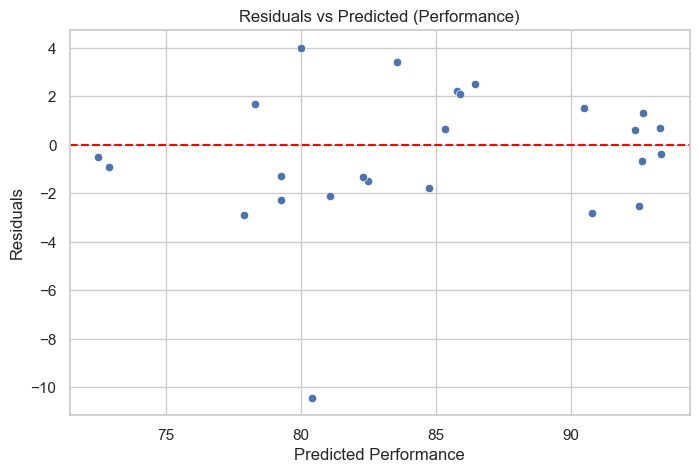

In [14]:
residuals = yr_test - yr_pred
plt.figure(figsize=(8,5))
sns.scatterplot(x=yr_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Performance')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted (Performance)')
plt.show()


Feature importance (regression)

Salary                  0.772974
YearsAtCompany          0.129729
Age                     0.085462
Department_Sales        0.006883
Department_Marketing    0.002560
Department_HR           0.002392
dtype: float64

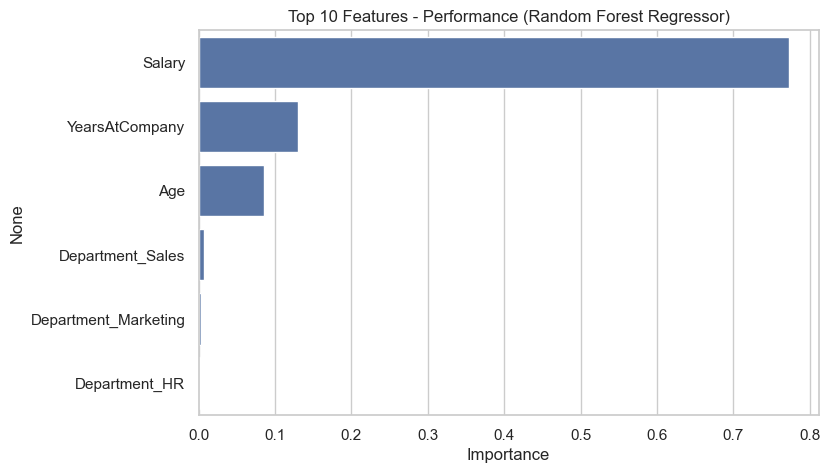

In [15]:
feat_imp_reg = pd.Series(rfr.feature_importances_, index=Xr_train.columns).sort_values(ascending=False)
display(feat_imp_reg.head(10))

plt.figure(figsize=(8,5))
sns.barplot(x=feat_imp_reg.head(10), y=feat_imp_reg.head(10).index)
plt.title('Top 10 Features - Performance (Random Forest Regressor)')
plt.xlabel('Importance')
plt.show()


(Optional) Hyperparameter tuning example — classifier

In [16]:
# Example: quick GridSearch for RandomForestClassifier (small grid to save time)
param_grid = {'n_estimators':[50,100], 'max_depth':[None,5,10]}
grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid.fit(Xc_train, yc_train)
print("Best params:", grid.best_params_)
print("Best CV score:", grid.best_score_)


Best params: {'max_depth': 5, 'n_estimators': 100}
Best CV score: 0.6666666666666666


Save trained models & scaler (optional)

In [17]:
import joblib
joblib.dump(rfc, 'rfc_attrition.pkl')
joblib.dump(rfr, 'rfr_performance.pkl')
joblib.dump(scaler, 'scaler_employee.pkl')
print("Models and scaler saved.")


Models and scaler saved.


Final notes (Markdown)

## Final Notes / Next Steps

- Check model metrics and tune hyperparameters for better performance.
- Try other models: LogisticRegression (classification), XGBoost/LightGBM (both).
- Use cross-validation for more robust estimates.

